# Ergodic Theory and Path-Dependent Visualizations

This notebook demonstrates the core ergodic theory concepts and path-dependent wealth evolution visualizations that form the mathematical foundation of the ergodic insurance framework.

## Key Concepts:
- **Time Average**: Growth rate experienced by a single entity over time
- **Ensemble Average**: Expected value across many parallel scenarios
- **Ergodic Divergence**: The separation between time and ensemble averages for multiplicative processes
- **Path Dependence**: How individual trajectories evolve differently despite identical statistical properties
- **Survivor Bias**: How averaging only over surviving paths misleads decision-making

## Setup and Imports

In [1]:
import sys
import os
from pathlib import Path

# Add parent directory to path for imports
module_path = Path.cwd().parent.parent
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Import visualization functions
from ergodic_insurance.src.visualization.technical_plots import (
    plot_ergodic_divergence,
    plot_path_dependent_wealth
)
from ergodic_insurance.src.ergodic_analyzer import ErgodicAnalyzer
from ergodic_insurance.src.simulation import Simulation
from ergodic_insurance.src.manufacturer import WidgetManufacturer
from ergodic_insurance.src.config_v2 import ManufacturerConfig, SimulationConfig

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 300
%matplotlib inline

## Generate Simulation Data

First, we'll generate trajectory data using the ergodic analyzer to calculate time and ensemble averages.

In [2]:
def generate_ergodic_data(n_paths=1000, max_years=1000, volatility=0.2, drift=0.08):
    """Generate data for ergodic analysis.
    
    Args:
        n_paths: Number of simulation paths
        max_years: Maximum time horizon
        volatility: Annual volatility
        drift: Expected annual return
        
    Returns:
        Dict with time horizons, averages, and trajectories
    """
    # Time horizons to analyze (logarithmic spacing)
    time_horizons = np.unique(np.logspace(0, np.log10(max_years), 50).astype(int))
    
    # Initialize storage
    time_averages = []
    ensemble_averages = []
    standard_errors = []
    
    # Generate full trajectories
    trajectories = np.ones((n_paths, max_years))
    
    for i in range(n_paths):
        # Generate geometric Brownian motion
        returns = np.random.normal(drift - volatility**2/2, volatility, max_years)
        growth_factors = np.exp(returns)
        trajectories[i] = np.cumprod(growth_factors)
    
    # Calculate statistics for each time horizon
    analyzer = ErgodicAnalyzer()
    
    for horizon in time_horizons:
        # Time average (average of log growth rates)
        time_avg_list = []
        for i in range(n_paths):
            if trajectories[i, horizon-1] > 0:
                time_avg = np.log(trajectories[i, horizon-1]) / horizon
                time_avg_list.append(time_avg)
        
        time_avg = np.mean(time_avg_list)
        time_averages.append(time_avg)
        
        # Ensemble average (expected log growth)
        ensemble_avg = drift - volatility**2/2  # Theoretical value
        ensemble_averages.append(drift)  # Without volatility drag for demonstration
        
        # Standard error
        se = np.std(time_avg_list) / np.sqrt(len(time_avg_list))
        standard_errors.append(se)
    
    return {
        'time_horizons': np.array(time_horizons),
        'time_averages': np.array(time_averages),
        'ensemble_averages': np.array(ensemble_averages),
        'standard_errors': np.array(standard_errors),
        'trajectories': trajectories
    }

# Generate the data
ergodic_data = generate_ergodic_data()
print(f"Generated {len(ergodic_data['trajectories'])} paths over {ergodic_data['trajectories'].shape[1]} years")
print(f"Analyzing {len(ergodic_data['time_horizons'])} different time horizons")

Generated 1000 paths over 1000 years
Analyzing 42 different time horizons


## Figure C1: Ergodic vs Ensemble Divergence

This visualization demonstrates the fundamental difference between time-average (ergodic) and ensemble-average growth rates. As the time horizon increases, these averages diverge, showing why insurance decisions must consider individual path dynamics rather than expected values.

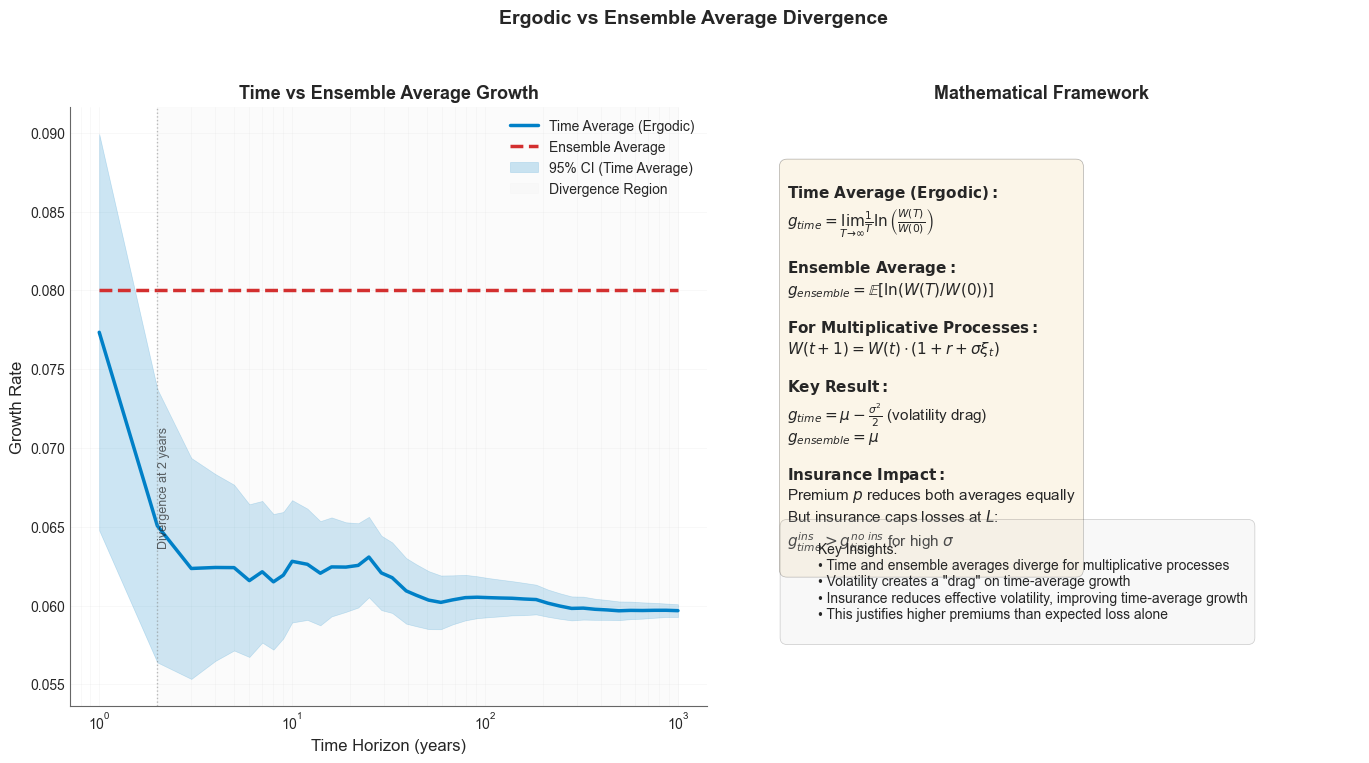


Key Observations:
1. Time and ensemble averages start similar but diverge over time
2. Time average includes volatility drag, reducing long-term growth
3. Confidence bands widen with time, showing increased uncertainty
4. This divergence justifies paying insurance premiums above expected loss


In [3]:
# Create basic ergodic divergence plot
fig1 = plot_ergodic_divergence(
    ergodic_data['time_horizons'],
    ergodic_data['time_averages'],
    ergodic_data['ensemble_averages'],
    standard_errors=ergodic_data['standard_errors'],
    title="Ergodic vs Ensemble Average Divergence",
    figsize=(14, 8)
)
plt.show()

print("\nKey Observations:")
print("1. Time and ensemble averages start similar but diverge over time")
print("2. Time average includes volatility drag, reducing long-term growth")
print("3. Confidence bands widen with time, showing increased uncertainty")
print("4. This divergence justifies paying insurance premiums above expected loss")

## Parameter Sensitivity Analysis

Let's examine how different volatility levels affect the divergence between time and ensemble averages.

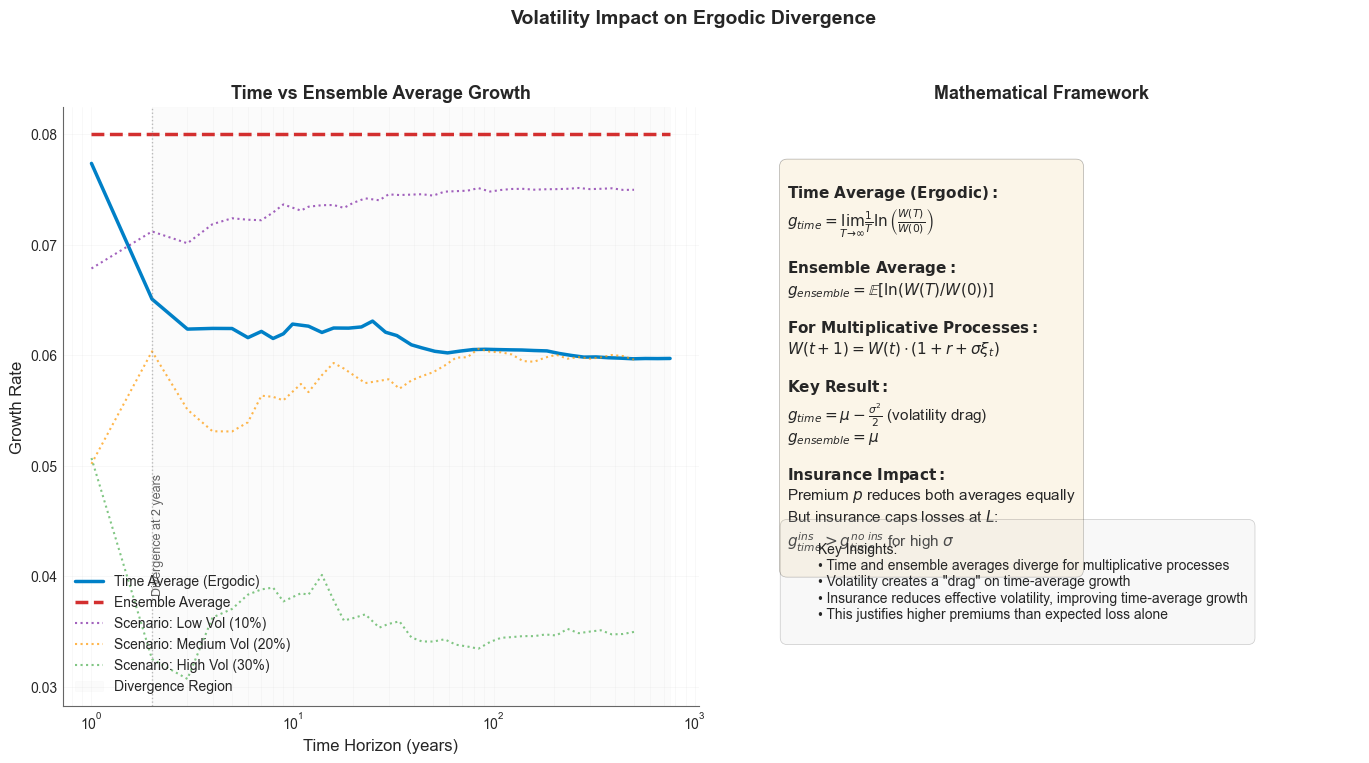


Volatility Impact Analysis:
- Higher volatility → Greater divergence
- Higher volatility → Lower time-average growth
- Insurance becomes MORE valuable with higher volatility
- This justifies higher insurance premiums in volatile environments


In [4]:
# Generate scenarios with different volatility levels
volatilities = {'Low Vol (10%)': 0.1, 'Medium Vol (20%)': 0.2, 'High Vol (30%)': 0.3}
scenarios = {}

for name, vol in volatilities.items():
    data = generate_ergodic_data(n_paths=500, max_years=500, volatility=vol)
    scenarios[name] = {
        'horizons': data['time_horizons'],
        'time_avg': data['time_averages']
    }

# Create plot with parameter scenarios
fig2 = plot_ergodic_divergence(
    ergodic_data['time_horizons'][:40],  # Limit to 500 years for clarity
    ergodic_data['time_averages'][:40],
    ergodic_data['ensemble_averages'][:40],
    parameter_scenarios=scenarios,
    title="Volatility Impact on Ergodic Divergence",
    figsize=(14, 8)
)
plt.show()

print("\nVolatility Impact Analysis:")
print("- Higher volatility → Greater divergence")
print("- Higher volatility → Lower time-average growth")
print("- Insurance becomes MORE valuable with higher volatility")
print("- This justifies higher insurance premiums in volatile environments")

## Figure C2: Path-Dependent Wealth Evolution

This visualization shows multiple wealth trajectories over time, highlighting paths that hit ruin and demonstrating survivor bias effects. It makes clear why ensemble averages mislead decision-making.

c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\ergodic_insurance\src\visualization\technical_plots.py:1602: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


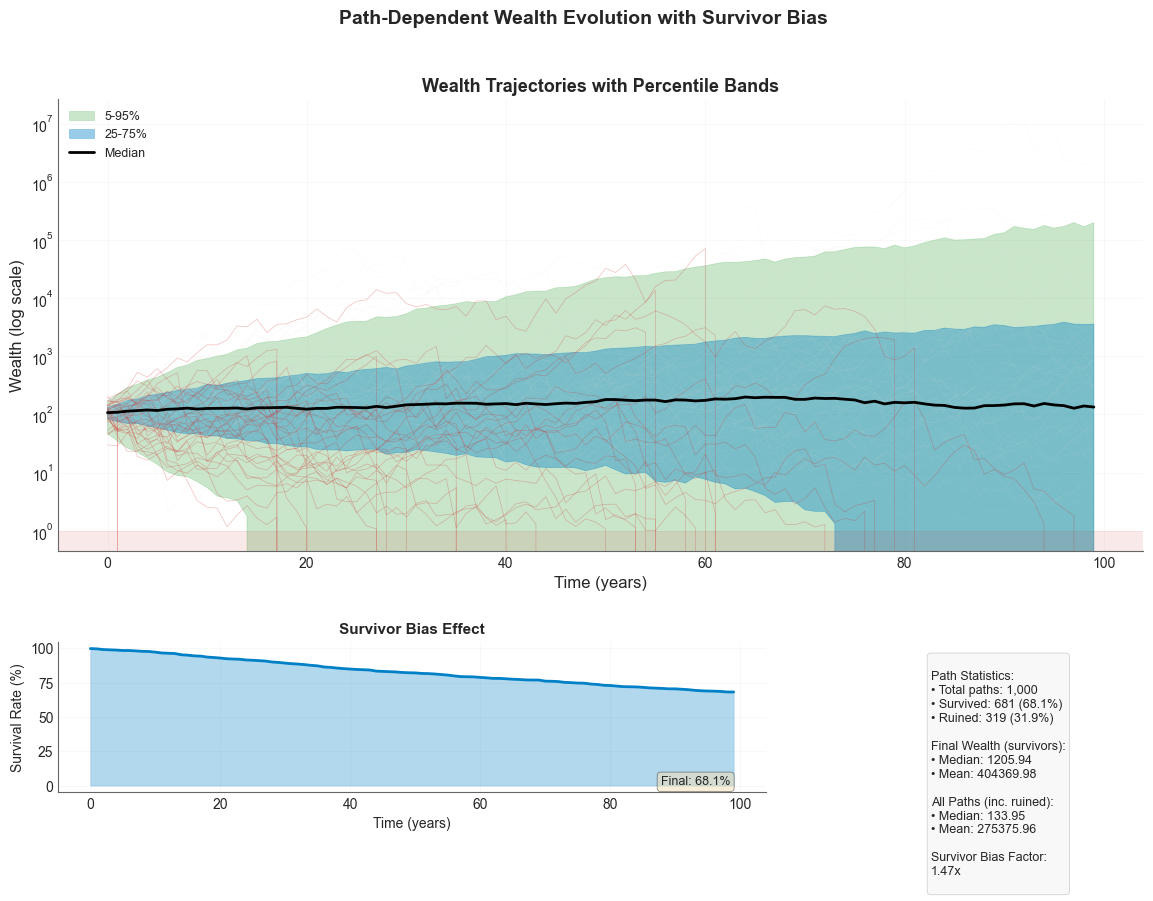


Path Statistics:
Total paths: 1000
Ruined paths: 319 (31.9%)
Mean wealth (survivors): $404369.98
Mean wealth (all paths): $275375.96
Survivor bias factor: 1.47x


In [5]:
# Generate wealth trajectories with possibility of ruin
def generate_wealth_trajectories(n_paths=500, n_years=100, volatility=0.25, leverage=1.5):
    """Generate wealth trajectories with potential for ruin.
    
    Args:
        n_paths: Number of paths to simulate
        n_years: Number of years
        volatility: Annual volatility
        leverage: Leverage factor (increases both returns and risk)
        
    Returns:
        Array of wealth trajectories
    """
    trajectories = np.ones((n_paths, n_years))
    initial_wealth = 100.0
    
    for i in range(n_paths):
        wealth = initial_wealth
        for t in range(n_years):
            # Leveraged returns with higher volatility
            shock = np.random.normal(0.06 * leverage, volatility * leverage)
            wealth *= (1 + shock)
            
            # Check for ruin (wealth below 1% of initial)
            if wealth < initial_wealth * 0.01:
                trajectories[i, t:] = 0
                break
            else:
                trajectories[i, t] = wealth
    
    return trajectories

# Generate trajectories
wealth_paths = generate_wealth_trajectories(n_paths=1000, n_years=100)

# Create path-dependent wealth plot
fig3 = plot_path_dependent_wealth(
    wealth_paths,
    ruin_threshold=1.0,
    percentiles=[5, 25, 50, 75, 95],
    highlight_ruined=True,
    add_survivor_bias_inset=True,
    title="Path-Dependent Wealth Evolution with Survivor Bias",
    figsize=(14, 9)
)
plt.show()

# Calculate statistics
final_wealth = wealth_paths[:, -1]
n_ruined = np.sum(final_wealth <= 1.0)
survivor_mean = np.mean(final_wealth[final_wealth > 1.0]) if np.any(final_wealth > 1.0) else 0
total_mean = np.mean(final_wealth)

print(f"\nPath Statistics:")
print(f"Total paths: {len(wealth_paths)}")
print(f"Ruined paths: {n_ruined} ({n_ruined/len(wealth_paths)*100:.1f}%)")
print(f"Mean wealth (survivors): ${survivor_mean:.2f}")
print(f"Mean wealth (all paths): ${total_mean:.2f}")
print(f"Survivor bias factor: {survivor_mean/total_mean if total_mean > 0 else 0:.2f}x")

## Insurance Impact on Path Evolution

Let's compare wealth trajectories with and without insurance to see how insurance affects the distribution of outcomes.

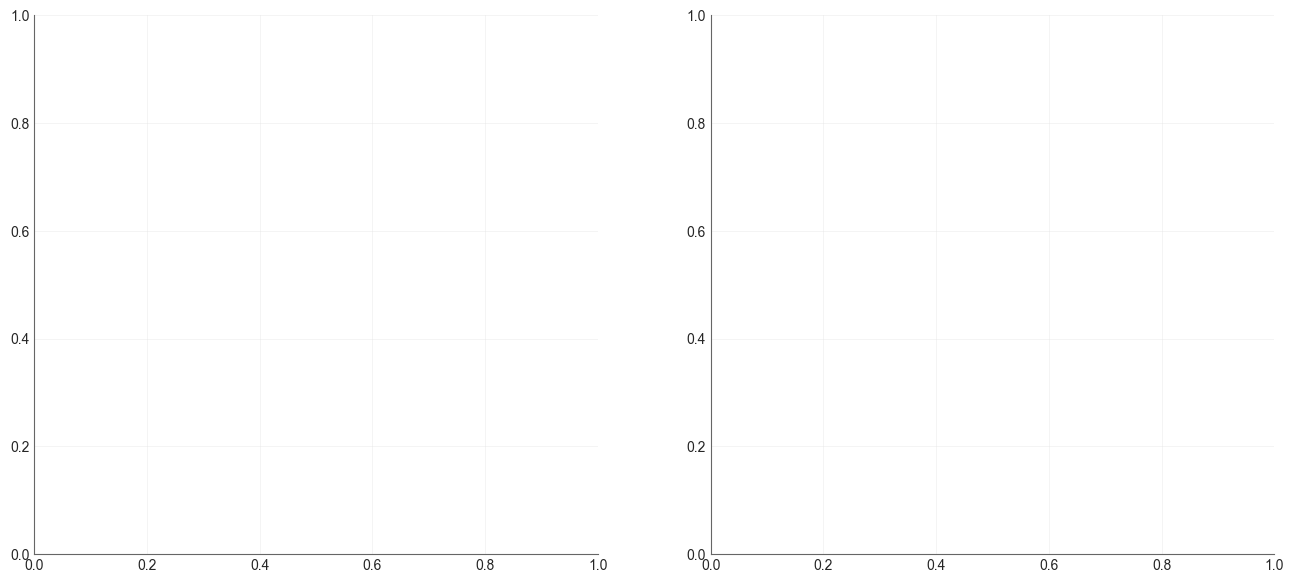

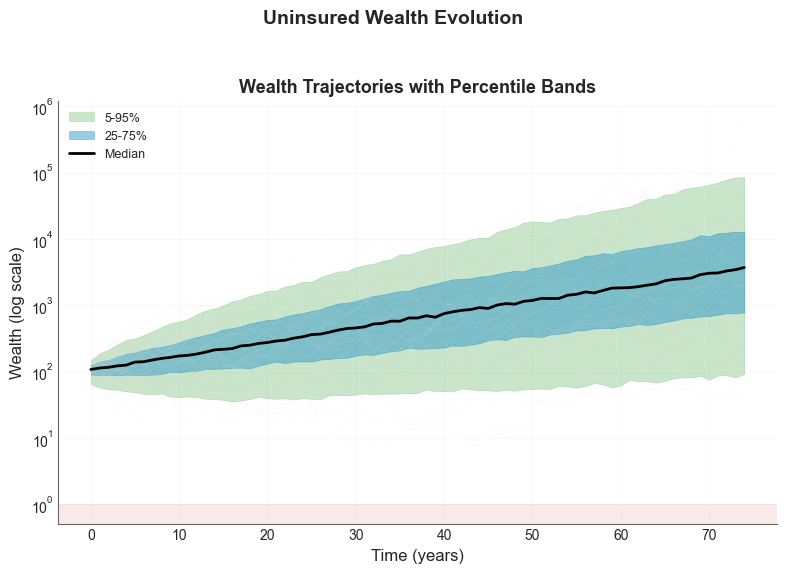

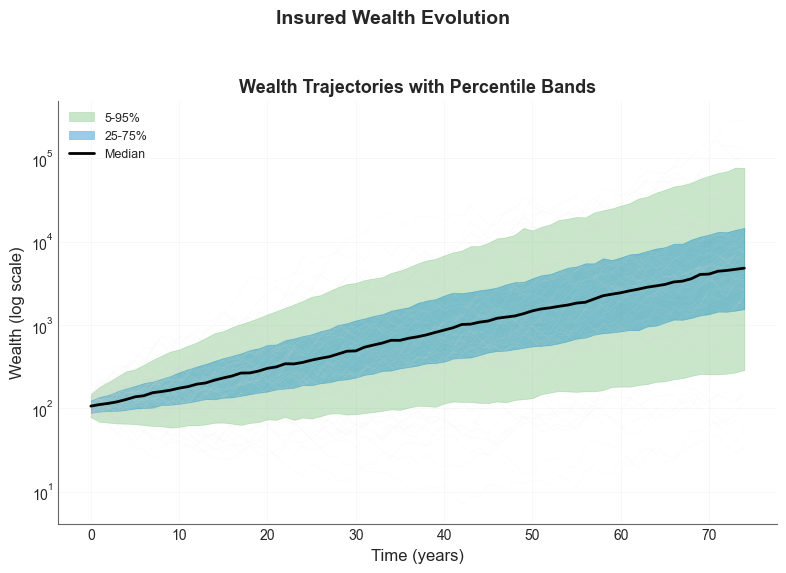


Insurance Impact Analysis:
Ruin probability (uninsured): 0.2%
Ruin probability (insured): 0.0%
Reduction in ruin probability: 0.2 percentage points

Median final wealth (uninsured): $3718.39
Median final wealth (insured): $4802.29

Conclusion: Insurance reduces extreme downside while preserving upside potential


In [10]:
def generate_insured_trajectories(n_paths=500, n_years=100, 
                                 insurance_premium=0.02, loss_cap=0.20):
    """Generate trajectories with insurance protection.
    
    Args:
        n_paths: Number of paths
        n_years: Number of years
        insurance_premium: Annual premium as fraction of wealth
        loss_cap: Maximum loss as fraction of wealth (insurance limit)
        
    Returns:
        Dict with uninsured and insured trajectories
    """
    uninsured = np.ones((n_paths, n_years))
    insured = np.ones((n_paths, n_years))
    initial_wealth = 100.0
    
    for i in range(n_paths):
        wealth_uninsured = initial_wealth
        wealth_insured = initial_wealth
        
        for t in range(n_years):
            # Generate shock
            base_return = 0.08
            volatility = 0.25
            shock = np.random.normal(base_return, volatility)
            
            # Uninsured path
            wealth_uninsured *= (1 + shock)
            if wealth_uninsured < 1.0:
                uninsured[i, t:] = 0
                wealth_uninsured = 0
            else:
                uninsured[i, t] = wealth_uninsured
            
            # Insured path (pay premium but cap losses)
            capped_shock = max(shock, -loss_cap)  # Insurance caps losses
            wealth_insured *= (1 + capped_shock - insurance_premium)
            if wealth_insured < 1.0:
                insured[i, t:] = 0
                wealth_insured = 0
            else:
                insured[i, t] = wealth_insured
    
    return {'uninsured': uninsured, 'insured': insured}

# Generate comparison data
comparison_data = generate_insured_trajectories(n_paths=800, n_years=75)

# Create plots for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot uninsured
fig4a = plot_path_dependent_wealth(
    comparison_data['uninsured'],
    ruin_threshold=1.0,
    add_survivor_bias_inset=False,
    title="Uninsured Wealth Evolution",
    figsize=(8, 6)
)

# Plot insured
fig4b = plot_path_dependent_wealth(
    comparison_data['insured'],
    ruin_threshold=1.0,
    add_survivor_bias_inset=False,
    title="Insured Wealth Evolution",
    figsize=(8, 6)
)

plt.show()

# Calculate comparative statistics
uninsured_ruin = np.mean(comparison_data['uninsured'][:, -1] <= 1.0) * 100
insured_ruin = np.mean(comparison_data['insured'][:, -1] <= 1.0) * 100
uninsured_median = np.median(comparison_data['uninsured'][:, -1])
insured_median = np.median(comparison_data['insured'][:, -1])

print("\nInsurance Impact Analysis:")
print(f"Ruin probability (uninsured): {uninsured_ruin:.1f}%")
print(f"Ruin probability (insured): {insured_ruin:.1f}%")
print(f"Reduction in ruin probability: {uninsured_ruin - insured_ruin:.1f} percentage points")
print(f"\nMedian final wealth (uninsured): ${uninsured_median:.2f}")
print(f"Median final wealth (insured): ${insured_median:.2f}")
print(f"\nConclusion: Insurance reduces extreme downside while preserving upside potential")

## Custom Time Points Analysis

Analyze wealth evolution at specific time points to understand the dynamics of path dependence.

c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\ergodic_insurance\src\visualization\technical_plots.py:1602: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


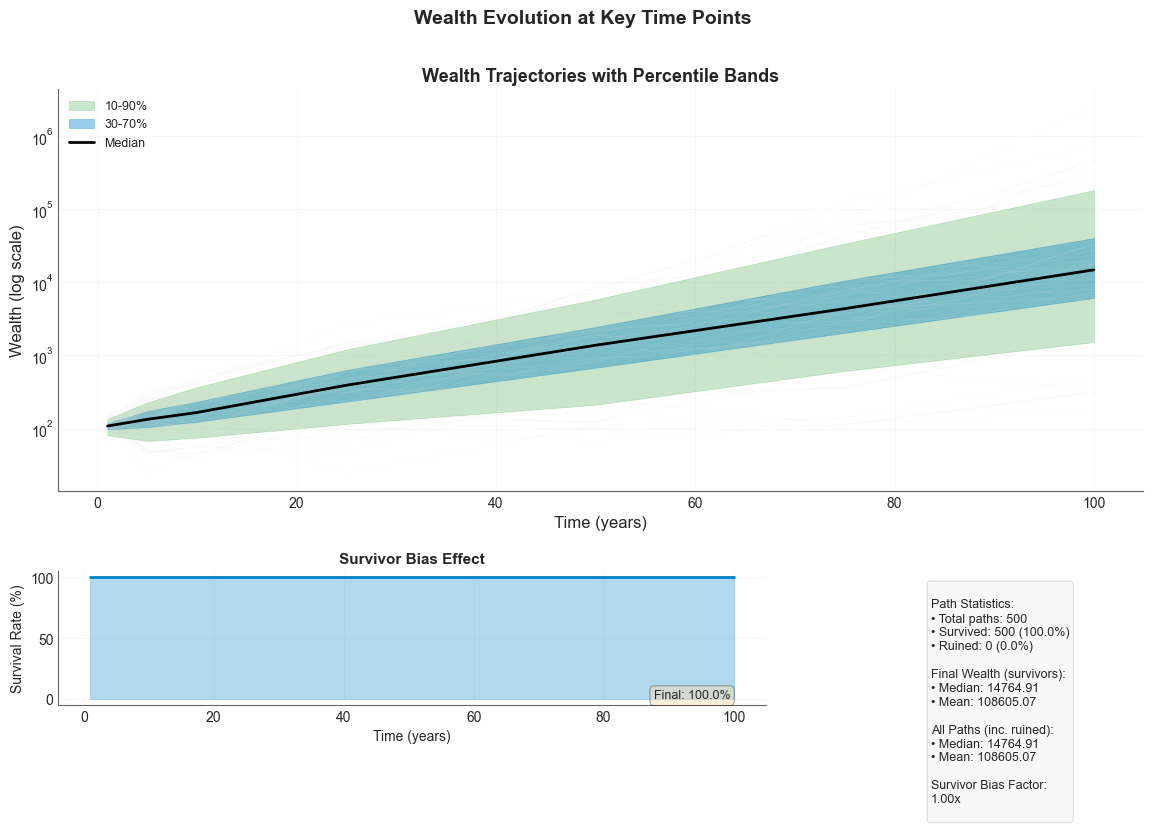


Wealth Dispersion Analysis:
Year   1: CV=0.19, Survival=100.0%
Year   5: CV=0.44, Survival=100.0%
Year  10: CV=0.62, Survival=100.0%
Year  25: CV=1.00, Survival=100.0%
Year  50: CV=1.81, Survival=100.0%
Year  75: CV=2.03, Survival=100.0%
Year 100: CV=4.61, Survival=100.0%


In [7]:
# Generate trajectories with specific time points of interest
key_time_points = np.array([1, 5, 10, 25, 50, 75, 100])  # Years
n_paths = 500

# Generate trajectories at these specific points
trajectories_at_points = np.ones((n_paths, len(key_time_points)))

for i in range(n_paths):
    wealth = 100.0
    for j, years in enumerate(key_time_points):
        # Simulate to this time point
        years_to_simulate = years if j == 0 else years - key_time_points[j-1]
        for _ in range(years_to_simulate):
            shock = np.random.normal(0.07, 0.20)
            wealth *= (1 + shock)
            if wealth < 1.0:
                wealth = 0
                break
        trajectories_at_points[i, j] = wealth

# Create visualization with custom time points
fig5 = plot_path_dependent_wealth(
    trajectories_at_points,
    time_points=key_time_points,
    ruin_threshold=1.0,
    percentiles=[10, 30, 50, 70, 90],
    title="Wealth Evolution at Key Time Points",
    figsize=(14, 8)
)
plt.show()

# Analyze dispersion over time
print("\nWealth Dispersion Analysis:")
for j, years in enumerate(key_time_points):
    values = trajectories_at_points[:, j]
    surviving = values[values > 1.0]
    if len(surviving) > 0:
        cv = np.std(surviving) / np.mean(surviving) if np.mean(surviving) > 0 else 0
        print(f"Year {years:3d}: CV={cv:.2f}, Survival={len(surviving)/n_paths*100:.1f}%")

## Summary and Key Insights

The visualizations in this notebook demonstrate several critical insights for insurance decision-making:

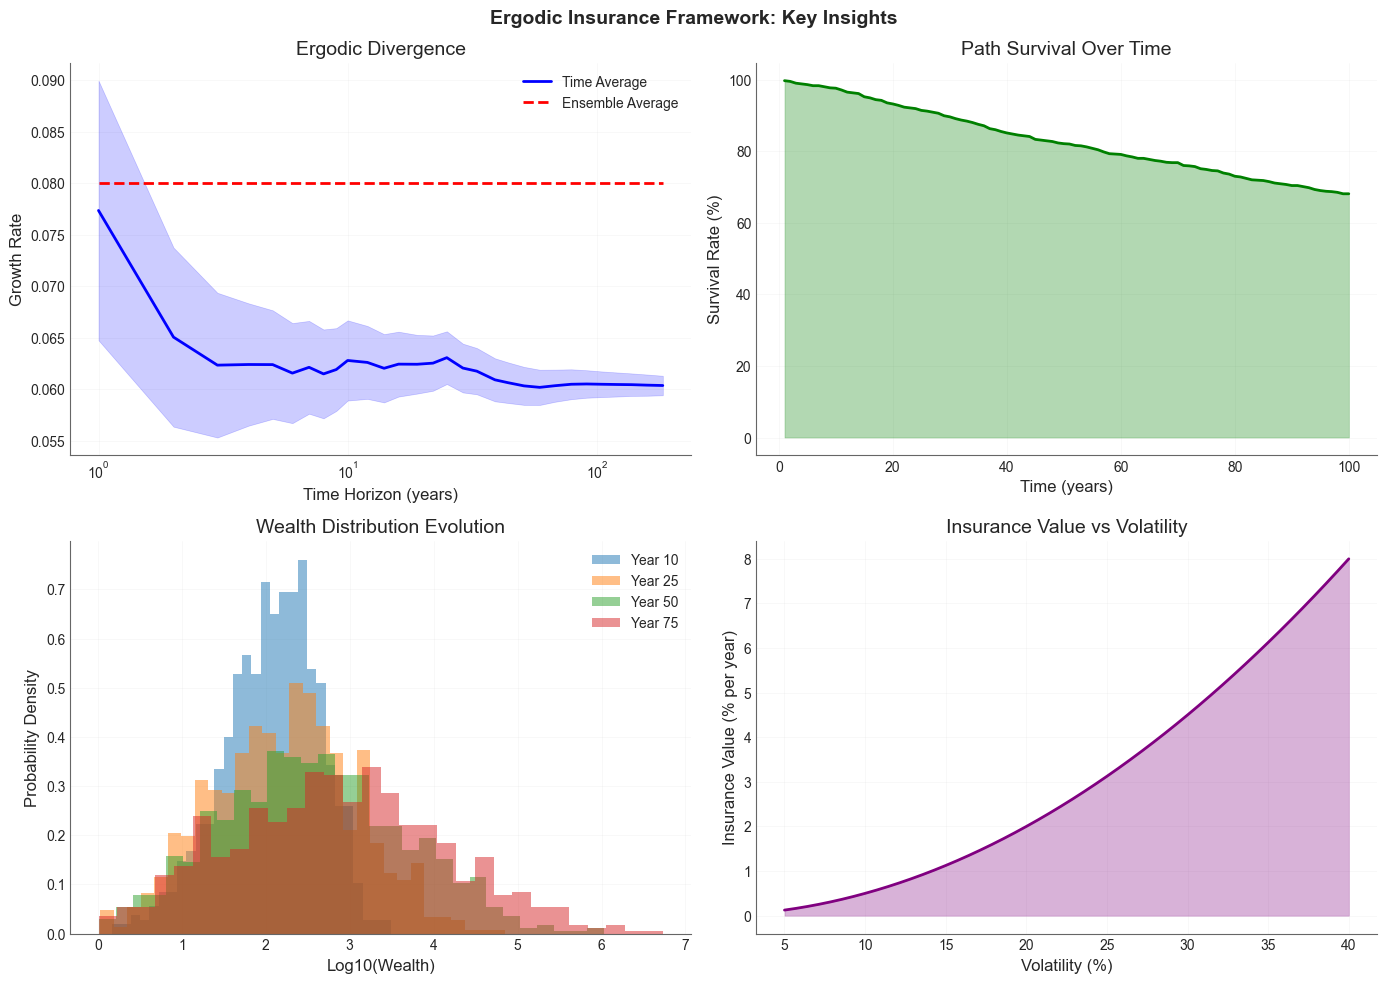


KEY INSIGHTS FROM ERGODIC ANALYSIS

1. TIME VS ENSEMBLE DIVERGENCE:
   - Time averages include volatility drag
   - Divergence increases with time horizon
   - Individual experience ≠ Expected value

2. PATH DEPENDENCE:
   - Many paths lead to ruin despite positive expected return
   - Survivor bias inflates perceived performance
   - Wealth inequality increases over time

3. INSURANCE JUSTIFICATION:
   - Insurance improves time-average growth
   - Value increases with volatility
   - Optimal premium > Expected loss

4. PRACTICAL IMPLICATIONS:
   - Focus on survival, not just expected return
   - Consider your specific path, not the average
   - Insurance is growth-enabling, not just protection


In [8]:
# Create a summary visualization combining key insights
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Time vs Ensemble Average
ax1 = axes[0, 0]
horizons_short = ergodic_data['time_horizons'][:30]
ax1.semilogx(horizons_short, ergodic_data['time_averages'][:30], 'b-', linewidth=2, label='Time Average')
ax1.semilogx(horizons_short, ergodic_data['ensemble_averages'][:30], 'r--', linewidth=2, label='Ensemble Average')
ax1.fill_between(horizons_short, 
                 ergodic_data['time_averages'][:30] - 2*ergodic_data['standard_errors'][:30],
                 ergodic_data['time_averages'][:30] + 2*ergodic_data['standard_errors'][:30],
                 alpha=0.2, color='blue')
ax1.set_xlabel('Time Horizon (years)')
ax1.set_ylabel('Growth Rate')
ax1.set_title('Ergodic Divergence')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Survival Rate Over Time
ax2 = axes[0, 1]
survival_rates = []
time_points = np.arange(1, 101)
for t in time_points:
    if t <= wealth_paths.shape[1]:
        survival_rate = np.mean(wealth_paths[:, t-1] > 1.0) * 100
        survival_rates.append(survival_rate)
ax2.plot(time_points[:len(survival_rates)], survival_rates, 'g-', linewidth=2)
ax2.fill_between(time_points[:len(survival_rates)], 0, survival_rates, alpha=0.3, color='green')
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Survival Rate (%)')
ax2.set_title('Path Survival Over Time')
ax2.grid(True, alpha=0.3)

# Panel 3: Wealth Distribution at Different Times
ax3 = axes[1, 0]
times_to_plot = [10, 25, 50, 75]
for t_idx, t in enumerate(times_to_plot):
    if t <= wealth_paths.shape[1]:
        surviving_wealth = wealth_paths[:, t-1][wealth_paths[:, t-1] > 1.0]
        if len(surviving_wealth) > 0:
            ax3.hist(np.log10(surviving_wealth), bins=30, alpha=0.5, 
                    label=f'Year {t}', density=True)
ax3.set_xlabel('Log10(Wealth)')
ax3.set_ylabel('Probability Density')
ax3.set_title('Wealth Distribution Evolution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Panel 4: Insurance Value Over Time
ax4 = axes[1, 1]
volatilities = np.linspace(0.05, 0.40, 50)
insurance_value = volatilities**2 / 2  # Approximation of time-average benefit
ax4.plot(volatilities * 100, insurance_value * 100, 'purple', linewidth=2)
ax4.fill_between(volatilities * 100, 0, insurance_value * 100, alpha=0.3, color='purple')
ax4.set_xlabel('Volatility (%)')
ax4.set_ylabel('Insurance Value (% per year)')
ax4.set_title('Insurance Value vs Volatility')
ax4.grid(True, alpha=0.3)

plt.suptitle('Ergodic Insurance Framework: Key Insights', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHTS FROM ERGODIC ANALYSIS")
print("="*60)
print("\n1. TIME VS ENSEMBLE DIVERGENCE:")
print("   - Time averages include volatility drag")
print("   - Divergence increases with time horizon")
print("   - Individual experience ≠ Expected value")
print("\n2. PATH DEPENDENCE:")
print("   - Many paths lead to ruin despite positive expected return")
print("   - Survivor bias inflates perceived performance")
print("   - Wealth inequality increases over time")
print("\n3. INSURANCE JUSTIFICATION:")
print("   - Insurance improves time-average growth")
print("   - Value increases with volatility")
print("   - Optimal premium > Expected loss")
print("\n4. PRACTICAL IMPLICATIONS:")
print("   - Focus on survival, not just expected return")
print("   - Consider your specific path, not the average")
print("   - Insurance is growth-enabling, not just protection")
print("="*60)

## Export Figures for Publication

Save the key figures in high resolution for use in reports and presentations.

In [9]:
# Create output directory if it doesn't exist
output_dir = Path('../../results/figures/ergodic_visualizations')
output_dir.mkdir(parents=True, exist_ok=True)

# Re-create and save Figure C1
fig_c1 = plot_ergodic_divergence(
    ergodic_data['time_horizons'],
    ergodic_data['time_averages'],
    ergodic_data['ensemble_averages'],
    standard_errors=ergodic_data['standard_errors'],
    title="Figure C1: Ergodic vs Ensemble Average Divergence"
)
fig_c1.savefig(output_dir / 'figure_c1_ergodic_divergence.png', dpi=300, bbox_inches='tight')
fig_c1.savefig(output_dir / 'figure_c1_ergodic_divergence.pdf', bbox_inches='tight')
plt.close(fig_c1)

# Re-create and save Figure C2
fig_c2 = plot_path_dependent_wealth(
    wealth_paths,
    ruin_threshold=1.0,
    title="Figure C2: Path-Dependent Wealth Evolution"
)
fig_c2.savefig(output_dir / 'figure_c2_path_dependent_wealth.png', dpi=300, bbox_inches='tight')
fig_c2.savefig(output_dir / 'figure_c2_path_dependent_wealth.pdf', bbox_inches='tight')
plt.close(fig_c2)

print(f"Figures saved to: {output_dir.absolute()}")
print("\nSaved files:")
for file in output_dir.glob('*'):
    print(f"  - {file.name}")

c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\ergodic_insurance\src\visualization\technical_plots.py:1602: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


Figures saved to: c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\ergodic_insurance\notebooks\..\..\results\figures\ergodic_visualizations

Saved files:
  - figure_c1_ergodic_divergence.pdf
  - figure_c1_ergodic_divergence.png
  - figure_c2_path_dependent_wealth.pdf
  - figure_c2_path_dependent_wealth.png
